# 🧠 Clasificador de Estado de Salud con PyTorch

Este proyecto utiliza una red neuronal profunda (MLP) implementada en PyTorch para clasificar el estado de salud de pacientes en tres categorías: **mala**, **regular** o **buena**, usando un conjunto de datos tabulares.

---


## Importar librerias

In [ ]:
# Manejo de datos
import numpy as np
import pandas as pd
import random
import os

# Modelos de Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from collections import Counter

#Preprocesamiento de datos
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Gráficos
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version torch: {torch.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")
print(f"{color}- Version sklearn: {pd.__version__}")

Versión de las librerias utilizadas:
- Version torch: 2.7.1+cpu
- Version pandas: 2.2.3
- Version numpy: 2.2.6
- Version sklearn: 2.2.3


## Lectura del dataset

In [2]:
#numero total de datos a usar de los 100k de datos
num_datos = 1001 #1k, 5k, 10k, 50k, 100k

In [ ]:
#Cargar Dataset
try:
    data = pd.read_csv(f'..\Datasets\dataset_original.csv')
    print("Archivo cargado correctamente.")
except Exception as e:
    print(f"Error: {e}")

Archivo cargado correctamente.


In [4]:
# Convertir variables categóricas a numéricas
data = pd.get_dummies(data, columns=['gender', 'smoking_history'], drop_first=True)

# Eliminar filas con valores nulos si los hubiera
data.dropna(inplace=True)

# Renombrar columnas para que no tengan caracteres especiales
data.columns = data.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)

print("Preprocesamiento listo. Nuevas columnas:")
print(data.columns)
data.head()
data_sample = data

Preprocesamiento listo. Nuevas columnas:
Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'diabetes', 'gender_Male', 'gender_Other',
       'smoking_history_current', 'smoking_history_ever',
       'smoking_history_former', 'smoking_history_never',
       'smoking_history_notcurrent'],
      dtype='object')


In [5]:
seed = 110425
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cpu


In [ ]:
#Resample manteniendo proporcion de datos original
class_0 = data[data['diabetes'] == 0].sample(n=int(num_datos*0.915), random_state=42) 
class_1 = data[data['diabetes'] == 1].sample(n=int(num_datos*0.085), random_state=42) 
balanced_train_data = pd.concat([class_0, class_1]).sample(frac=1, random_state=42).reset_index(drop=True)
data_sample = balanced_train_data

--- Distribución de clases en la muestra del 10% ---
diabetes
0    915
1     85
Name: count, dtype: int64
--------------------------------------------------


In [ ]:
# 1. Separar características (x) y objetivo (y) de la muestra
x = data_sample.drop(columns=["diabetes"]).to_numpy()
y = data_sample["diabetes"].to_numpy()

# 2. Dividir en conjuntos de entrenamiento, validación y prueba 
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, stratify=y) # 20% para test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=y_train) # 15% del resto para validación

# 3. Aplicar el escalado
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val) # Usar el mismo scaler del train
X_test = scaler.transform(X_test) # Usar el mismo scaler del train


Counter({np.int64(0): 915, np.int64(1): 85})

Pesos iniciales calculados (más alto para clases raras):
[1.092896174863388, 11.764705882352942]

Tensor de pesos para CrossEntropyLoss: tensor([ 1.0929, 11.7647])


In [ ]:
#Aplicar Tensores
#Train
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

#Val
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

#Test
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [ ]:
#Definir Batchs
batchsize = 32
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = DiabetesDataset(X_train, y_train)
val_data = DiabetesDataset(X_val, y_val)
test_data = DiabetesDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batchsize, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=False)

In [11]:
#Definir un modelo para trabajar

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hc1 = nn.Linear(x.shape[1], 256) # Ajuste automático al número de columnas
        self.hc2 = nn.Linear(256, 128)
        self.hc3 = nn.Linear(128, 64)
        self.hc4 = nn.Linear(64, 2)
        self.act = nn.LeakyReLU()
        self.dp1 = nn.Dropout(0.4)
        self.dp2 = nn.Dropout(0.2)

    def forward(self, input):
        l1 = self.dp1(self.act(self.hc1(input)))
        l2 = self.dp2(self.act(self.hc2(l1)))
        l3 = self.act(self.hc3(l2))
        output = self.hc4(l3)
        return output

In [ ]:
# Inicializa el Modelo, define el Learning Rate y el optimizador
testeo = MLP()
lr = 1e-4
opt = torch.optim.Adam(testeo.parameters(), lr=lr, weight_decay=1e-4)

#Calcula peso para las clases para posteriormente darle mas importancia las clases minoritaria
class_counts = Counter(y)
print(class_counts)
total_samples = len(y)
num_classes = len(class_counts)
class_weights = [0.0] * num_classes
for class_id, count in class_counts.items():
    class_weights[class_id] = total_samples / count
print("\nPesos iniciales calculados (más alto para clases raras):")
print(class_weights)
weights_tensor = torch.tensor(class_weights, dtype=torch.float)
print(f"\nTensor de pesos para CrossEntropyLoss: {weights_tensor}")

#Se define loss con los weight previamente calculados
loss_func = nn.CrossEntropyLoss(weight=weights_tensor)


In [ ]:
# Direccion donde estan o se guardarn los pesos y el modelo
testeo_path = f'../Guardar_modelo/MLP/Binary_original/Binary_original_{num_datos}_pytorch.pth'
testeo_path_FULL = f'../Guardar_modelo/MLP/Binary_original/Binary_original_{num_datos}_pytorch_FULL.pth'

In [ ]:
# Cargar Pesos
#testeo.load_state_dict(torch.load(testeo_path))
# Cargar Modelo
#testeo = torch.load(testeo_path_FULL)

In [ ]:
#Entrenamiento

n_epochs = 2000

history = {
    "TL" : [],
    "VL" : []
}

early_stopping = {
    "delta" : 1e-5,
    "patience": 10
}

best_val_loss = float("inf")
aux = 0

for i in range(n_epochs+1):
    testeo.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:  
      output = testeo(X_batch)
      loss = loss_func(output, y_batch) 
      
      opt.zero_grad()
      loss.backward()
      opt.step()

      epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    history["TL"].append(epoch_loss)

    testeo.eval()
    epoch_loss = 0
    for X_batch, y_batch in val_loader:
      with torch.no_grad():
        preds_val = testeo(X_batch)
      val_loss = loss_func(preds_val, y_batch)

      epoch_loss += val_loss.item()
    epoch_loss /= len(val_loader)
    history["VL"].append(epoch_loss)
    
    if epoch_loss + early_stopping["delta"] < best_val_loss:
      best_val_loss = epoch_loss
      aux = 0
    else:
      aux += 1
      if aux >= early_stopping["patience"]:
        print(f"Terminando el entrenamiento en la época {i}")
        break
    

Terminando el entrenamiento en la época 44


In [ ]:
#Guardar Pesos
torch.save(testeo.state_dict(), testeo_path)
#Guardar Modelo Completo
torch.save(testeo, testeo_path_FULL)

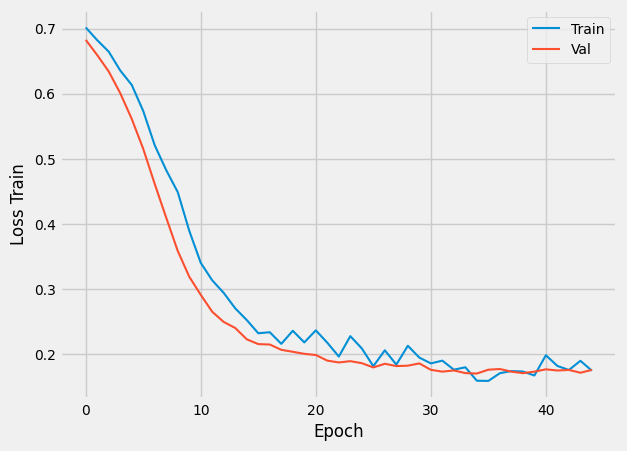

In [ ]:
#Grafico de loss en tre training y validacion
plt.plot(history["TL"], label="Train")
plt.plot(history["VL"], label="Val")
plt.xlabel('Epoch')
plt.ylabel('Loss Train')
plt.legend()
plt.show()

In [ ]:
#calculo de accuracy
#Train 
with torch.no_grad():
    output_train = testeo(X_train)
y_hat_train = output_train.numpy()
y_hat_train = [np.argmax(i) for i in y_hat_train]
print(f'Training Accuracy: {accuracy_score(y_train, y_hat_train):.2f}')
#Testeo 
with torch.no_grad():
    output = testeo(X_test)  
y_hat = output.numpy()
y_hat = [np.argmax(i) for i in y_hat]
print(f'Testing Accuracy: {accuracy_score(y_test, y_hat):.2f}')
print(classification_report(y_test, y_hat))

Training Accuracy: 0.93
Testing Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       183
           1       0.56      0.82      0.67        17

    accuracy                           0.93       200
   macro avg       0.77      0.88      0.81       200
weighted avg       0.95      0.93      0.94       200



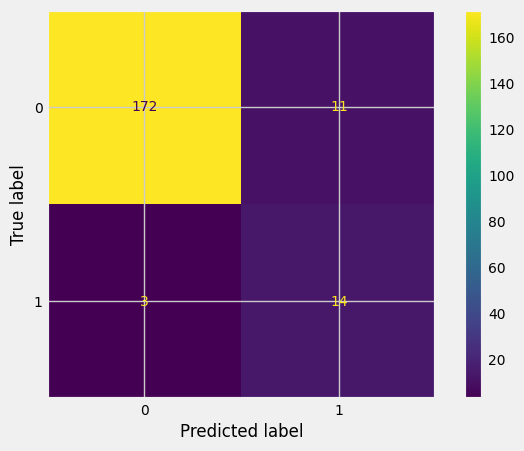

In [ ]:
cm =confusion_matrix(y_test, y_hat)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_plot.plot()
plt.show()